In [50]:
from pathlib import Path
import sys, os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import json
from tqdm import tqdm
import esm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dictionary import AutoEncoder
from trainer import StandardTrainer
from training import train_run
from dataset import ProteinDataset, collate_batch
from config import my_config

In [28]:
# Load ESM-2 model
if my_config["plm_name"] == 'esm2_t33_650M_UR50D':
    esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
elif my_config["plm_name"] == 'esm1b_t33_650M_UR50S':
    esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    
esm_model = esm_model.to(my_config['device'])
norm_b = esm_model.emb_layer_norm_after.bias.clone().detach().requires_grad_(False).to(my_config['device'])
norm_w = esm_model.emb_layer_norm_after.weight.clone().detach().requires_grad_(False).to(my_config['device'])

stage = my_config['stage']
df = pd.read_csv(my_config[f'df_path_{stage}'], nrows=1000)
df = df[df['split'] == 'train'].reset_index(drop=True)

dataset = ProteinDataset(df=df, df_name_col=my_config[f'df_name_col_{stage}'], embed_logit_path=my_config[f'embed_logit_path_{stage}'], stage=stage)
loader = DataLoader(dataset, collate_fn=collate_batch, batch_size=my_config['batch_size'], drop_last=True, num_workers=my_config['dataloader_num_workers'], shuffle = True)

In [18]:
my_config["plm_name"]

'esm2_t33_650M_UR50D'

### Why tied weight initialization result in good logit prediction?

In [20]:
sae = AutoEncoder(my_config['activation_dim'], my_config['dict_size'], tied=my_config['tied'])
sae = sae.to(my_config['device'])

In [29]:
for batch_data in loader:
    with torch.no_grad():
        act = batch_data['repr'].to(my_config['device'])
        logit = esm_model.lm_head(act)
        
        act_norm = (act.to(my_config["device"]) - norm_b) / norm_w
        act_norm_hat = sae(act_norm)
        act_hat = act_norm_hat * norm_w + norm_b
        logit_hat = esm_model.lm_head(act_hat)

    break

In [41]:
en = sae.encoder.weight.detach().cpu().numpy()
de = sae.decoder.weight.detach().cpu().numpy()
a = np.dot(de, en)

<Axes: >

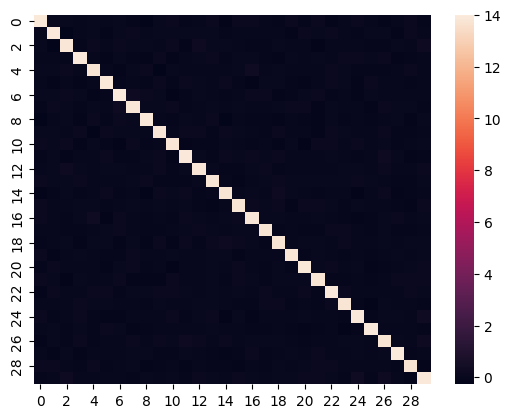

In [53]:
sns.heatmap(a[:30, :30])

Text(0, 0.5, 'reconstruction')

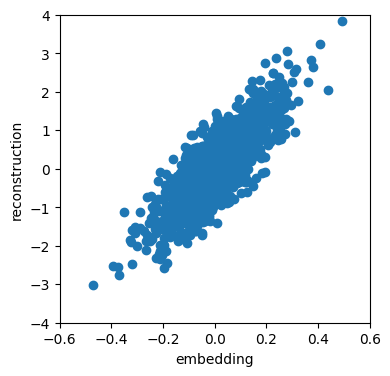

In [56]:
plt.figure(figsize=(4, 4))  
plt.scatter(act[0].cpu().numpy(), act_hat[0].cpu().numpy())
plt.xlim(-0.6, 0.6)
plt.ylim(-4, 4)
plt.xlabel('embedding')
plt.ylabel('reconstruction')
plt.show()

In [3]:
esm2, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm2.eval()  # disables dropout for deterministic results
esm2 = esm2.to(my_config['device'])
batch_converter = alphabet.get_batch_converter()

In [ ]:
trainer = StandardTrainer(
    activation_dim = my_config['activation_dim'],
    dict_size = my_config['dict_size'],
    warmup_steps=my_config['warmup_steps'],
    resample_steps=my_config['resample_steps'],
    lr=my_config['lr'],
    l1_penalty=my_config['l1_penalty'],
    l1_annealing_pct=my_config['l1_annealing_pct'],
    seed=my_config['seed'],
    wandb_name=my_config['wandb_name'],
    layer=my_config['layer'],
    plm_name=my_config['plm_name'],
    save_dir=my_config['save_dir'],
    device=my_config['device'],
    steps=my_config['steps'],
)
    
trainer_config = trainer.config
print(f"Training with config: {trainer_config}")

Training with config: {'dict_class': 'AutoEncoder', 'trainer_class': 'StandardTrainer', 'activation_dim': 1280, 'dict_size': 40960, 'lr': 0.001, 'l1_penalty': 0.1, 'l1_annealing_steps': 5000, 'warmup_steps': 1000, 'resample_steps': 100, 'device': 'cuda:0', 'layer': 33, 'plm_name': 'esm2_t33_650M_UR50D', 'wandb_name': 'wandb_name', 'submodule_name': None}


In [ ]:
train_run(
    # Core training components
    data=loader,
    trainer=trainer,

    # Evaluation settings
    fidelity_fn=None,
    eval_steps=None,

    epoch = my_config['epoch']
    # Logging and checkpointing
    save_dir=my_config['save_dir'],
    log_steps=my_config['log_steps'],
    save_steps=my_config['save_steps'],
    max_ckpts_to_keep=3,
)

  4%|▍         | 123/2895 [02:26<55:12,  1.19s/it]  


KeyboardInterrupt: 

: 